In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import tensorwatch as tw

import gym
import math
import random
import cv2
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from wrappers import make_env

NOTEBOOK_MODE = True
if NOTEBOOK_MODE:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm


env = gym.make('Pong-v0').unwrapped
if NOTEBOOK_MODE:
    # set up matplotlib to open viewing window
    is_ipython = 'inline' in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
import gym
import argparse
import math
import os
import tensorwatch as tw

import torch
import torch.optim as optim
import torch.nn.functional as F

# from apex import amp # playing around with mixed-precision training

# Local Imports
from models import Qnet
from wrappers import make_env
from memory import ReplayBuffer
from helpers import saveTrainedGameplay, get_state
from settings import device

In [4]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

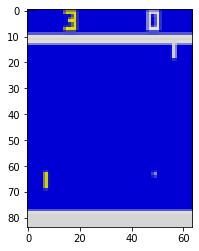

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(64, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    # convert to channel,h,w dimensions
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # erase background
    screen[screen == 72] = 0 
    screen[screen == 74] = 0 
    screen[screen == 144] = 0 
    screen[screen != 0] = 213
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    screen = torch.from_numpy(screen)
    
    # convert to batch,channel,h,w dimensions
    return resize(screen).unsqueeze(0).to(device)

if NOTEBOOK_MODE:
    env.reset()
    # run game for a bit to load the ball and opponent paddle
    for i in range(50):
        env.step(0)
    plt.figure()
    plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.show()

In [118]:
'''
    Optimizes our training policy by computing the Huber Loss between our minibatch of samples and the maximum possible reward for the next state(s)
    Huber Loss here is defined as:
    loss(x,y) = \frac{1}{n}\sum{z_i}, where z_i = 0.5(x_i-y_i)^2; if |x_i - y_i| < 1 or 
                                                = |x_i - y_i| - 0.5; otherwise
'''
def train(q, q_target, memory, optimizer, batch_size, gamma):
    s,a,r,s_prime,done_mask = memory.sample(batch_size)
    
    q_out = q(s)
    # collect output from the chosen action dimension
    q_a = q_out.gather(1,a) 
    
    # most reward we get in next state s_prime
    max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
    target = r + gamma * max_q_prime * done_mask

    # how much is our policy different from the true target 
    loss = F.smooth_l1_loss(q_a, target)
    
    optimizer.zero_grad()

    #with amp.scale_loss(loss, optimizer) as scaled_loss: # playing around with mixed-precision training
    	#scaled_loss.backward()
    loss.backward()
    optimizer.step()



#def main(num_episodes, episode_start = 1, saved_model = None, save_loc = 'checkpoints/tmp/'):
#watcher = tw.Watcher()
num_episodes = 100
episode_start = 1
saved_model = 'checkpoints/4channel/target_bot_1500.pt'
save_loc = None
# Model parameters 
learning_rate = 1e-4 # 0.0001 matches paper
gamma = 0.98
buffer_limit = 10 ** 5 # paper uses 1M last frames, but this is expensive, so we try 10x less
batch_size = 32

# Epsilon Decay Parameters
eps_start = 1
eps_end = 0.01
decay_factor = 10 ** 5

epsilon_decay = lambda x: eps_end + (eps_start - eps_end) * \
    math.exp(-1. * x / decay_factor)

env = gym.make('PongNoFrameskip-v4')
env = make_env(env)
h, w = 84, 84


# Initialize the policy (q) network, target network, and experience replay buffer
q = Qnet(h,w, in_channels = 4, n_actions = 4).to(device)
q_target = Qnet(h,w, in_channels = 4, n_actions = 4).to(device)
memory = ReplayBuffer(buffer_limit = buffer_limit)

if saved_model:
    # Set epsilon decay function to eps_end
    epsilon_decay = lambda x: eps_end
    # Load pretrained model
    q.load_state_dict(torch.load(saved_model))

# Load policy weights into target network
q_target.load_state_dict(q.state_dict())
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

save_interval = 250
print_interval = 1
update_target_interval = 1000 # every 1000 frames
score = 0.0


#[q, q_target], optimizer = amp.initialize([q, q_target], optimizer, opt_level="O1") #playing around with mixed-precision training
total_frames = 0
best_episode_score = -100
for episode in tqdm(range(episode_start,episode_start + num_episodes)):
    # anneal 100% to 1% over training
    epsilon = epsilon_decay(total_frames)

    # Reset Environment for each game
    state = get_state(env.reset())
    episode_score = 0
    done = False
    while not done:
        total_frames += 1
        action = q.sample_action(state.to(device), epsilon)

        obs, reward, done, info = env.step(action)

        next_state = get_state(obs)

        done_mask = 0.0 if done else 1.0
        memory.put((state,action,reward,next_state,done_mask))

        state = next_state

        score += reward
        episode_score += reward

        if memory.size() > 10000:
            train(q, q_target, memory, optimizer, batch_size, gamma)
        if total_frames%update_target_interval == 0:
            q_target.load_state_dict(q.state_dict())
        if done:
            break

    if episode_score > best_episode_score:
        best_episode_score = episode_score

    if episode%print_interval==0 and episode!=0:
        print("n_episode : {}, Total Frames : {}, Average Score : {:.1f}, Episode Score : {:.1f}, Best Score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
            episode, total_frames, score/episode, episode_score, best_episode_score, memory.size(), epsilon*100))

''' # Microsoft Tensorwatch Watcher for Visualizing Training
watcher.observe(
    episode = episode,
    episode_score = episode_score,
    total_score = score,
    buffer_size = memory.size(),
    epsilon = epsilon,
    frames = total_frames,
)'''

n_episode : 1, Total Frames : 1660, Average Score : 21.0, Episode Score : 21.0, Best Score : 21.0, n_buffer : 1660, eps : 1.0%
n_episode : 2, Total Frames : 3386, Average Score : 21.0, Episode Score : 21.0, Best Score : 21.0, n_buffer : 3386, eps : 1.0%


KeyboardInterrupt: 

In [126]:
#train(q, q_target, memory, optimizer, batch_size, gamma)
s,a,r,s_prime,done_mask = memory.sample(batch_size)

q_out = q(s)
# collect output from the chosen action dimension
q_a = q_out.gather(1,a) 

# most reward we get in next state s_prime
max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
target = r + gamma * max_q_prime * done_mask

# how much is our policy different from the true target 
loss = F.smooth_l1_loss(q_a, target)

optimizer.zero_grad()

#with amp.scale_loss(loss, optimizer) as scaled_loss: # playing around with mixed-precision training
    #scaled_loss.backward()
print(loss)
loss.backward()
optimizer.step()

tensor(4.2262e-05, device='cuda:0', grad_fn=<MeanBackward0>)


# Double DQN Training

In [127]:
#s,a,r,s_prime,done_mask = memory.sample(batch_size)
# Q_out is the observed transitions given the current network
q_out = q(s)
# collect output from the chosen action dimension
q_a = q_out.gather(1,a)

# DDQN Update
argmax_q = q(s_prime).argmax(1).unsqueeze(1)
# most reward we get in next state s_prime
q_prime = q_target(s_prime).gather(1,argmax_q)
# most reward we get in next state s_prime
target = r + gamma * q_prime * done_mask

# how much is our policy different from the true target 
loss = F.smooth_l1_loss(q_a, target)
optimizer.zero_grad()
print(loss)
#with amp.scale_loss(loss, optimizer) as scaled_loss: # playing around with mixed-precision training
    #scaled_loss.backward()
loss.backward()
optimizer.step()

tensor(3.8967e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [117]:
loss

tensor(0.1825, device='cuda:0', grad_fn=<MeanBackward0>)

In [103]:
argmax_q = q(s_prime).argmax(1).unsqueeze(1)
print(argmax_q.shape)
q_prime = q_target(s_prime).gather(1,argmax_q)

torch.Size([32, 1])


In [105]:
q_prime - max_q_prime

tensor([[-0.6189],
        [-0.6451],
        [-0.5358],
        [-0.5710],
        [-0.6022],
        [-0.5232],
        [-0.5109],
        [-0.5574],
        [-0.4999],
        [-0.4616],
        [-0.5134],
        [-0.5512],
        [-0.4987],
        [-0.4735],
        [-0.5795],
        [-0.4905],
        [-0.4650],
        [-0.4160],
        [-0.5555],
        [-0.6042],
        [-0.5089],
        [-0.4629],
        [-0.5191],
        [-0.4783],
        [-0.4981],
        [-0.8057],
        [-0.4388],
        [-0.5428],
        [-0.5365],
        [-0.5361],
        [-0.3484],
        [-0.7088]], device='cuda:0', grad_fn=<SubBackward0>)

In [98]:
max_q_prime - 

tensor([[0.3769],
        [0.4085],
        [0.3843],
        [0.3430],
        [0.3344],
        [0.2934],
        [0.3056],
        [0.2465],
        [0.3038],
        [0.3145],
        [0.2961],
        [0.3676],
        [0.3487],
        [0.2906],
        [0.3746],
        [0.2893],
        [0.3307],
        [0.2630],
        [0.3658],
        [0.3887],
        [0.3147],
        [0.2595],
        [0.3265],
        [0.2814],
        [0.2880],
        [0.4896],
        [0.2535],
        [0.3020],
        [0.3423],
        [0.3628],
        [0.3557],
        [0.4702]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [78]:
argmax_q

tensor([[0.7731],
        [0.7055],
        [0.8860],
        [0.8373],
        [0.7286],
        [0.7353],
        [0.7801],
        [0.6656],
        [0.7737],
        [0.8700],
        [0.7707],
        [0.7990],
        [0.8587],
        [0.7206],
        [0.7947],
        [0.8649],
        [0.8186],
        [0.8612],
        [0.7996],
        [0.7409],
        [0.8448],
        [0.7313],
        [0.8361],
        [0.8069],
        [0.8215],
        [0.7335],
        [0.8288],
        [0.7494],
        [0.7890],
        [0.7461],
        [1.0747],
        [0.8251]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [ ]:
# record trained agent gameplay

frames = []

env.reset()
current_s = get_screen()
done = False
last_s = get_screen()
current_s = get_screen()
s = last_s - current_s
epsilon = 0.0
while not done:
    a = q.sample_action(s, epsilon) + 2
    
    # use environment's frame instead of preprocessed get_screen()
    next_frame, _, done, info = env.step(a)
    frames.append(next_frame)
    last_s = current_s
    current_s = get_screen()
    s_prime = last_s - current_s

    done_mask = 0.0 if done else 1.0
    s = s_prime
    if done:
        break

In [ ]:
# save game to video 
height, width = frames[0].shape[:2] 

writer = cv2.VideoWriter_fourcc('M','J','P','G')
fps = 30
video_file = 'playback.avi'
out = cv2.VideoWriter(video_file, writer, fps, (width,height))
for frame in frames:
    out.write(frame)

out.release()

In [1]:
from DDQN import DDQN
import gym

In [2]:
from wrappers import make_env
env = gym.make('PongNoFrameskip-v4')
env = make_env(env)
ddqn = DDQN(env, save_location = "checkpoints/pong/")

In [3]:
ddqn.run(100)

  1%|          | 1/100 [00:09<15:31,  9.40s/it]

n_episode : 1, Total Frames : 834, Average Score : -20.0, Episode Score : -20.0, Best Score : -20.0, n_buffer : 834, eps : 100.0%


  2%|▏         | 2/100 [00:18<15:20,  9.39s/it]

n_episode : 2, Total Frames : 1679, Average Score : -20.5, Episode Score : -21.0, Best Score : -20.0, n_buffer : 1679, eps : 99.2%


  3%|▎         | 3/100 [00:27<14:45,  9.13s/it]

n_episode : 3, Total Frames : 2440, Average Score : -20.7, Episode Score : -21.0, Best Score : -20.0, n_buffer : 2440, eps : 98.4%


  4%|▍         | 4/100 [00:37<15:08,  9.46s/it]

n_episode : 4, Total Frames : 3372, Average Score : -20.8, Episode Score : -21.0, Best Score : -20.0, n_buffer : 3372, eps : 97.6%


  5%|▌         | 5/100 [00:49<15:57, 10.08s/it]

n_episode : 5, Total Frames : 4420, Average Score : -20.6, Episode Score : -20.0, Best Score : -20.0, n_buffer : 4420, eps : 96.7%


  6%|▌         | 6/100 [00:58<15:27,  9.87s/it]

n_episode : 6, Total Frames : 5260, Average Score : -20.7, Episode Score : -21.0, Best Score : -20.0, n_buffer : 5260, eps : 95.7%


  7%|▋         | 7/100 [01:09<15:40, 10.11s/it]

n_episode : 7, Total Frames : 6230, Average Score : -20.6, Episode Score : -20.0, Best Score : -20.0, n_buffer : 6230, eps : 94.9%


  8%|▊         | 8/100 [01:20<16:02, 10.46s/it]

n_episode : 8, Total Frames : 7254, Average Score : -20.4, Episode Score : -19.0, Best Score : -19.0, n_buffer : 7254, eps : 94.0%


  9%|▉         | 9/100 [01:28<14:56,  9.85s/it]

n_episode : 9, Total Frames : 8013, Average Score : -20.4, Episode Score : -21.0, Best Score : -19.0, n_buffer : 8013, eps : 93.1%


 10%|█         | 10/100 [01:37<14:07,  9.42s/it]

n_episode : 10, Total Frames : 8772, Average Score : -20.5, Episode Score : -21.0, Best Score : -19.0, n_buffer : 8772, eps : 92.4%


 11%|█         | 11/100 [01:45<13:31,  9.12s/it]

n_episode : 11, Total Frames : 9529, Average Score : -20.5, Episode Score : -21.0, Best Score : -19.0, n_buffer : 9529, eps : 91.7%


NameError: name 'F' is not defined